# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
import os
from collections import namedtuple
pd.set_option("display.max_rows",35)
%matplotlib inline

In [2]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    kdd_test__2labels = pd.read_pickle("dataset/kdd_test__2labels.pkl")
    
    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [3]:
dataset.kdd_train_2labels.shape

(125973, 124)

In [4]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [5]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Normal','is_Attack']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]

    x_test__input = dataset.kdd_test__2labels.drop(output_columns_2labels, axis = 1)
    y_test_ = dataset.kdd_test__2labels.loc[:,output_columns_2labels]
    
    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)
    x_test_ = ss.transform(x_test__input)

    y_train = y_output.values
    y_test = y_test.values
    y_test_ = y_test_.values

    x_train = np.hstack((x_train, y_train))
    x_test = np.hstack((x_test, np.random.normal(size = (x_test.shape[0], y_train.shape[1]))))
    x_test_ = np.hstack((x_test_, np.random.normal(size = (x_test_.shape[0], y_train.shape[1]))))

    #x_test = np.hstack((x_test, y_test))
    
preprocess.x_train.std()

0.99186991653217405

In [6]:
import tensorflow as tf


In [7]:
class network(object):
    
    input_dim = 124
    classes = 2
    hidden_encoder_dim = 124
    hidden_layers = 1
    latent_dim = 10

    hidden_decoder_dim = 124
    lam = 0.01
    
    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        hidden_decoder_dim = self.hidden_decoder_dim
        lam = self.lam
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
            self.lr = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Mean"):
            mu_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Layer_Variance"):
            logvar_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Sampling_Distribution"):
            # Sample epsilon
            epsilon = tf.random_normal(tf.shape(logvar_encoder), mean=0, stddev=1, name='epsilon')

            # Sample latent variable
            std_encoder = tf.exp(0.5 * logvar_encoder)
            z = mu_encoder + tf.multiply(std_encoder, epsilon)
            
            #tf.summary.histogram("Sample_Distribution", z)

        with tf.variable_scope("Layer_Decoder"):
            hidden_decoder = tf.layers.dense(z, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_decoder = tf.layers.dense(hidden_decoder, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Reconstruction"):
            self.x_hat = tf.layers.dense(hidden_decoder, input_dim, activation = None)
            
            self.y = tf.slice(self.x_hat, [0,input_dim-2], [-1,-1])

        with tf.variable_scope("Loss"):
            
            self.regularized_loss = tf.losses.mean_squared_error(self.x, self.x_hat) #tf.reduce_mean((BCE + KLD + softmax_loss) * lam)
            loss = tf.where(tf.is_nan(self.regularized_loss), 1e-2, self.regularized_loss)
            
            correct_prediction = tf.equal(tf.argmax(self.y, 1), tf.argmax(self.y_, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate= self.lr #1e-2
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [8]:
import collections
import time

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score', 'test_score_20', 'time_taken'])

    predictions = {}

    results = []
    best_acc = 0
    best_acc_global = 0
    
    def train(epochs, net, h, f, lrs):
        batch_iterations = 200
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_vae_only_nsl_kdd/hidden layers_{}_features count_{}".format(epochs,h,f),
                    exist_ok = True)
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            start_time = time.perf_counter()
            for lr in lrs:
                for epoch in range(1, (epochs+1)):
                    #print("Step {} | Training Loss:".format(epoch), end = " " )
                    x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                              preprocess.y_train, 
                                                                              test_size=0.1)
                    batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                               batch_iterations)

                    for i in batch_indices:

                        def train_batch():
                            nonlocal train_loss
                            _, train_loss = sess.run([net.train_op, 
                                                      net.regularized_loss, 
                                                      ], #net.summary_op
                                                      feed_dict={net.x: x_train[i,:], 
                                                                 net.y_: y_train[i,:], 
                                                                 net.keep_prob:1, net.lr:lr})

                        train_batch()

                        count = 10
                        if((train_loss > 1e4 or np.isnan(train_loss) ) and epoch > 1 and count > 1):
                            print("Step {} | High Training Loss: {:.6f} ... Restoring Net".format(epoch, train_loss))
                            net.saver.restore(sess, 
                                              tf.train.latest_checkpoint('dataset/tf_vae_only_nsl_kdd/hidden layers_{}_features count_{}'
                                                                         .format(epochs,h,f)))
                            train_batch()
                            count -= 1

                        #summary_writer_train.add_summary(summary_str, epoch)
                        #if(train_loss > 1e9):

                        #print("{:.6f}".format(train_loss), end = ", " )

                    #print("")
                    valid_loss, valid_accuracy = sess.run([net.regularized_loss, net.tf_accuracy], feed_dict={net.x: x_valid, 
                                                                         net.y_: y_valid, 
                                                                         net.keep_prob:1, net.lr:lr})


                    accuracy, test_loss, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, net.regularized_loss, 
                                                                   net.pred, 
                                                                   net.actual, net.y], 
                                                                  feed_dict={net.x: preprocess.x_test, 
                                                                             net.y_: preprocess.y_test, 
                                                                             net.keep_prob:1, net.lr:lr})
                    accuracy_, test_loss_, pred_value_, actual_value_, y_pred_ = sess.run([net.tf_accuracy, net.regularized_loss, 
                                                                                           net.pred, 
                                                                                           net.actual, net.y], 
                                                                                          feed_dict={net.x: preprocess.x_test_, 
                                                                                                     net.y_: preprocess.y_test_, 
                                                                                                     net.keep_prob:1, net.lr:lr})
                    #print("*************** \n")
                    print("Step {} | Training Loss: {:.6f} | Test Loss: {:6f} | Test Accuracy: {:.6f}, {:.6f}".format(epoch, train_loss, test_loss, accuracy, accuracy_))
                    #print("*************** \n")
                    #print("Accuracy on Test data: {}".format(accuracy))


                    if accuracy > Train.best_acc_global:
                        Train.best_acc_global = accuracy
                        Train.pred_value = pred_value
                        Train.actual_value = actual_value
                        Train.pred_value_ = pred_value_
                        Train.actual_value_ = actual_value_
                        Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)

                    if accuracy > Train.best_acc:

                        #net.saver.save(sess, "dataset/tf_vae_only_nsl_kdd_hidden layers_{}_features count_{}".format(epochs,h,f))
                        #Train.results.append(Train.result(epochs, f, h,valid_accuracy, accuracy))
                        #curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1]})
                        #Train.predictions.update({"{}_{}_{}".format(epochs,f,h):curr_pred})

                        Train.best_acc = accuracy
                        if not (np.isnan(train_loss)):
                            net.saver.save(sess, 
                                       "dataset/tf_vae_only_nsl_kdd/hidden layers_{}_features count_{}/model"
                                       .format(epochs,h,f), 
                                       global_step = epoch, 
                                       write_meta_graph=False)

                        curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value})
                        Train.predictions.update({"{}_{}_{}".format(epochs*len(lrs),f,h):
                                                  (curr_pred, 
                                                   Train.result(epochs*len(lrs), f, h,valid_accuracy, accuracy, accuracy_, time.perf_counter() - start_time))})

            

In [ ]:
import itertools
class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]



    def start_training():

        global df_results
        global past_scores
        
        Train.predictions = {}
        Train.results = []
        
        features_arr = [8, 32, 122]
        hidden_layers_arr = [3, 5]

        epochs = [15]
        lrs = [1e-2, 1e-2, 1e-3]

        for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
            print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
            n = network(2,h,f)
            n.build_layers()
            Train.train(e, n, h,f, lrs)

        dict1 = {}
        dict2 = []
        for k, (v1, v2) in Train.predictions.items():
            dict1.update({k: v1})
            dict2.append(v2)
            
        Train.predictions = dict1
        Train.results = dict2
        df_results = pd.DataFrame(Train.results)
        temp = df_results.set_index(['no_of_features', 'hidden_layers'])

        if not os.path.isfile('dataset/tf_vae_only_nsl_kdd_all.pkl'):
            past_scores = temp
        else:
            past_scores = pd.read_pickle("dataset/tf_vae_only_nsl_kdd_all.pkl")

        past_scores.append(temp).to_pickle("dataset/tf_vae_only_nsl_kdd_all.pkl")

        

In [ ]:
%%timeit -r 10

Hyperparameters.start_training()

Current Layer Attributes - epochs:15 hidden layers:3 features count:8
Step 1 | Training Loss: 0.466580 | Test Loss: 1.281702 | Test Accuracy: 0.777502, 0.584641
Step 2 | Training Loss: 0.327729 | Test Loss: 1.212881 | Test Accuracy: 0.836498, 0.691983
Step 3 | Training Loss: 0.258304 | Test Loss: 1.156412 | Test Accuracy: 0.751375, 0.623207
Step 4 | Training Loss: 0.183690 | Test Loss: 1.244708 | Test Accuracy: 0.761932, 0.592743
Step 5 | Training Loss: 0.310612 | Test Loss: 1.284593 | Test Accuracy: 0.797019, 0.640084
Step 6 | Training Loss: 0.205378 | Test Loss: 1.148312 | Test Accuracy: 0.761977, 0.561435
Step 7 | Training Loss: 0.138747 | Test Loss: 1.374767 | Test Accuracy: 0.786817, 0.611308
Step 8 | Training Loss: 0.477039 | Test Loss: 1.456718 | Test Accuracy: 0.758827, 0.552658
Step 9 | Training Loss: 0.817190 | Test Loss: 1.404510 | Test Accuracy: 0.773377, 0.606413
Step 10 | Training Loss: 0.601043 | Test Loss: 1.744578 | Test Accuracy: 0.747427, 0.544641
Step 11 | Training 

Step 9 | Training Loss: 0.595067 | Test Loss: 1.693841 | Test Accuracy: 0.802431, 0.710295
Step 10 | Training Loss: 0.291139 | Test Loss: 1.702601 | Test Accuracy: 0.802431, 0.707089
Step 11 | Training Loss: 0.429782 | Test Loss: 1.722091 | Test Accuracy: 0.803229, 0.699831
Step 12 | Training Loss: 0.383797 | Test Loss: 1.722682 | Test Accuracy: 0.799858, 0.694937
Step 13 | Training Loss: 0.340998 | Test Loss: 1.706284 | Test Accuracy: 0.810193, 0.706160
Step 14 | Training Loss: 0.396882 | Test Loss: 1.742761 | Test Accuracy: 0.809705, 0.699831
Step 15 | Training Loss: 0.434638 | Test Loss: 1.684222 | Test Accuracy: 0.780784, 0.727426
Current Layer Attributes - epochs:15 hidden layers:3 features count:122
Step 1 | Training Loss: 0.667167 | Test Loss: 1.817722 | Test Accuracy: 0.786107, 0.604388
Step 2 | Training Loss: 0.579525 | Test Loss: 1.781187 | Test Accuracy: 0.786684, 0.597975
Step 3 | Training Loss: 0.726052 | Test Loss: 1.771572 | Test Accuracy: 0.831751, 0.685823
Step 4 | Tra

Step 8 | Training Loss: 0.655106 | Test Loss: 1.925077 | Test Accuracy: 0.870520, 0.781603
Step 9 | Training Loss: 0.832828 | Test Loss: 1.925123 | Test Accuracy: 0.870431, 0.781350
Step 10 | Training Loss: 1.708123 | Test Loss: 1.924730 | Test Accuracy: 0.868346, 0.777300
Step 11 | Training Loss: 0.839824 | Test Loss: 1.924186 | Test Accuracy: 0.865286, 0.770042
Step 12 | Training Loss: 0.721813 | Test Loss: 1.923875 | Test Accuracy: 0.866439, 0.772911
Step 13 | Training Loss: 1.203005 | Test Loss: 1.926491 | Test Accuracy: 0.857834, 0.753671
Step 14 | Training Loss: 0.979997 | Test Loss: 1.928997 | Test Accuracy: 0.847764, 0.731730
Step 15 | Training Loss: 0.821829 | Test Loss: 1.930167 | Test Accuracy: 0.835433, 0.711814
Current Layer Attributes - epochs:15 hidden layers:5 features count:32
Step 1 | Training Loss: 0.588801 | Test Loss: 1.713101 | Test Accuracy: 0.793870, 0.611899
Step 2 | Training Loss: 0.831626 | Test Loss: 1.616760 | Test Accuracy: 0.764638, 0.559072
Step 3 | Trai

Step 14 | Training Loss: 0.908868 | Test Loss: 1.983569 | Test Accuracy: 0.430758, 0.181603
Step 15 | Training Loss: 0.802643 | Test Loss: 1.983806 | Test Accuracy: 0.430758, 0.181603
Step 1 | Training Loss: 0.890940 | Test Loss: 1.983346 | Test Accuracy: 0.430758, 0.181603
Step 2 | Training Loss: 0.790125 | Test Loss: 1.983743 | Test Accuracy: 0.430758, 0.181603
Step 3 | Training Loss: 0.829183 | Test Loss: 1.983646 | Test Accuracy: 0.430758, 0.181603
Step 4 | Training Loss: 0.816010 | Test Loss: 1.983248 | Test Accuracy: 0.430758, 0.181603
Step 5 | Training Loss: 0.899832 | Test Loss: 1.983193 | Test Accuracy: 0.430758, 0.181603
Step 6 | Training Loss: 1.250924 | Test Loss: 1.983675 | Test Accuracy: 0.430758, 0.181603
Step 7 | Training Loss: 0.908405 | Test Loss: 1.983618 | Test Accuracy: 0.430758, 0.181603
Step 8 | Training Loss: 0.959557 | Test Loss: 1.983244 | Test Accuracy: 0.430758, 0.181603
Step 9 | Training Loss: 1.025066 | Test Loss: 1.983758 | Test Accuracy: 0.430758, 0.1816

In [11]:
g = df_results.groupby(by=['no_of_features'])
idx = g['test_score'].transform(max) == df_results['test_score']
df_results[idx].sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score,test_score_20,time_taken
5,45,122,5,0.934593,0.869500,0.760169,77.890941
4,45,32,5,0.797904,0.856547,0.789705,86.243578
0,45,8,3,0.944912,0.850381,0.732489,71.239707


In [12]:
df_results.sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score,test_score_20,time_taken
5,45,122,5,0.934593,0.869500,0.760169,77.890941
2,45,122,3,0.886252,0.868302,0.757131,95.354419
4,45,32,5,0.797904,0.856547,0.789705,86.243578
0,45,8,3,0.944912,0.850381,0.732489,71.239707
1,45,32,3,0.915304,0.837473,0.733418,78.966704
3,45,8,5,0.959597,0.823811,0.680759,26.700803


In [13]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_vae_only_nsl_kdd_predictions.pkl")
df_results.to_pickle("dataset/tf_vae_only_nsl_kdd_scores.pkl")

AttributeError: 'tuple' object has no attribute 'shape'

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix
    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, preprocess.output_columns_2labels, normalize = True,
                         title = Train.best_parameters)

Normalized confusion matrix
[[ 0.9258  0.0742]
 [ 0.1409  0.8591]]


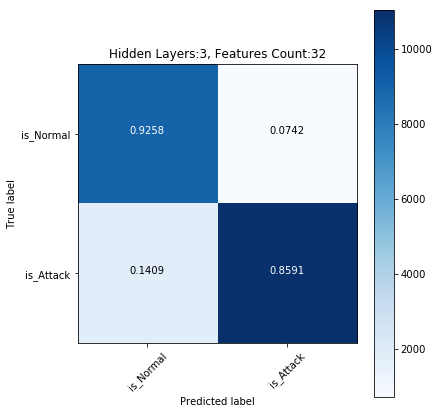

In [15]:
plot(actual_value = Train.actual_value, pred_value = Train.pred_value)

Normalized confusion matrix
[[ 0.7505  0.2495]
 [ 0.1829  0.8171]]


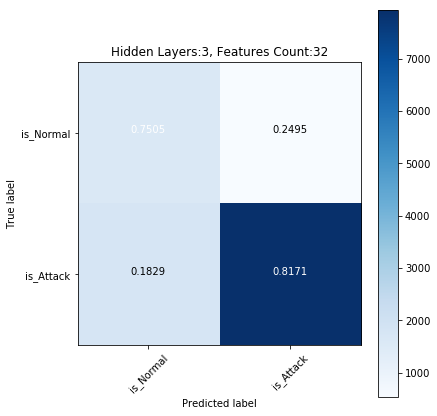

In [16]:
plot(actual_value = Train.actual_value_, pred_value = Train.pred_value_)

In [17]:
past_scores

,,epoch,train_score,test_score,test_score_20,time_taken
no_of_features,hidden_layers,,,,,
1,1,45,0.928639,0.774973,0.689114,16.006346
8,1,45,0.948801,0.810238,0.676034,5.418028
32,1,45,0.952215,0.811391,0.649367,6.201481
122,1,45,0.533339,0.430758,0.181603,4.315096
1,3,45,0.933243,0.833304,0.694684,33.188258
8,3,45,0.961343,0.790188,0.609198,5.809257
32,3,45,0.959914,0.860140,0.749705,171.153311
122,3,45,0.927449,0.809572,0.642869,51.082118
1,5,45,0.865693,0.854152,0.740759,374.074049


In [18]:
pgb = past_scores.groupby(by=['no_of_features', 'hidden_layers'])
pgb.mean()

epoch  train_score  test_score  test_score_20  \
no_of_features hidden_layers                                                  
1              1                 45     0.928639    0.774973       0.689114   
               3                 45     0.933243    0.833304       0.694684   
               5                 45     0.865693    0.854152       0.740759   
8              1                 45     0.948801    0.810238       0.676034   
               3                 45     0.949694    0.819409       0.666414   
               5                 45     0.925643    0.863855       0.774789   
32             1                 45     0.952215    0.811391       0.649367   
               3                 45     0.957434    0.855416       0.754726   
               5                 45     0.948147    0.838671       0.713291   
122            1                 45     0.533339    0.430758       0.181603   
               3                 45     0.928699    0.830676       0.698333   
               5                 45     0.924889    0.867792       0.755992   

                              time_taken  
no_of_features hidden_layers              
1              1               16.006346  
               3               33.188258  
               5              374.074049  
8              1                5.418028  
               3               10.127202  
               5               68.479426  
32             1                6.201481  
               3              108.730500  
               5              117.740169  
122            1                4.315096  
               3               58.181932  
               5               35.209097

In [19]:
pgb.std()

epoch  train_score  test_score  test_score_20  \
no_of_features hidden_layers                                                  
1              1                0.0     0.000000    0.000000       0.000000   
               3                0.0     0.000000    0.000000       0.000000   
               5                0.0     0.000000    0.000000       0.000000   
8              1                0.0     0.000000    0.000000       0.000000   
               3                0.0     0.017912    0.035165       0.070939   
               5                0.0     0.031737    0.014655       0.036771   
32             1                0.0     0.000000    0.000000       0.000000   
               3                0.0     0.002917    0.007854       0.006480   
               5                0.0     0.015226    0.026191       0.060474   
122            1                0.0     0.000000    0.000000       0.000000   
               3                0.0     0.009732    0.029346       0.084747   
               5                0.0     0.009613    0.023526       0.047023   

                              time_taken  
no_of_features hidden_layers              
1              1                0.000000  
               3                0.000000  
               5                0.000000  
8              1                0.000000  
               3                8.666701  
               5               31.574623  
32             1                0.000000  
               3               72.192987  
               5              108.510321  
122            1                0.000000  
               3               43.666248  
               5               18.832000